In [63]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully")

Libraries imported successfully


## 1. Load Data from Data Warehouse

In [64]:
# Connect to the data warehouse
conn = sqlite3.connect('../data/diabetes_dwh.db')

# Load all data with joins
query = """
SELECT 
    p.patient_id,
    p.age,
    p.height_cm,
    p.weight_kg,
    p.bmi,
    f.fasting_glucose,
    f.hba1c,
    rf.sedentary_lifestyle,
    rf.family_history,
    rf.smoking_status,
    rf.diet_quality,
    rf.physical_activity,
    f.diabetes_diagnosis as target
FROM fact_patient_measures f
JOIN dim_patient p ON f.patient_id = p.patient_id
JOIN dim_risk_factors rf ON f.risk_factor_id = rf.risk_factor_id
"""

df = pd.read_sql_query(query, conn)
conn.close()

print(f"Dataset loaded: {df.shape}")
print(f"\nFeatures: {df.columns.tolist()}")
print(f"\nClass distribution:")
print(df['target'].value_counts())
print(f"\nClass balance: {df['target'].value_counts(normalize=True) * 100}")

Dataset loaded: (250, 13)

Features: ['patient_id', 'age', 'height_cm', 'weight_kg', 'bmi', 'fasting_glucose', 'hba1c', 'sedentary_lifestyle', 'family_history', 'smoking_status', 'diet_quality', 'physical_activity', 'target']

Class distribution:
target
1    151
0     99
Name: count, dtype: int64

Class balance: target
1    60.4
0    39.6
Name: proportion, dtype: float64


## 2. Exploratory Data Analysis

In [65]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Basic statistics
print("\nBasic statistics:")
print(df.describe())

Missing values:
patient_id             0
age                    0
height_cm              0
weight_kg              0
bmi                    0
fasting_glucose        0
hba1c                  0
sedentary_lifestyle    0
family_history         0
smoking_status         0
diet_quality           0
physical_activity      0
target                 0
dtype: int64

Basic statistics:
       patient_id         age   height_cm   weight_kg         bmi  \
count  250.000000  250.000000  250.000000  250.000000  250.000000   
mean   125.500000   50.924000  170.012000   77.240720   26.988037   
std     72.312977   17.043007   15.566797   15.806865    5.979752   
min      1.000000    1.000000   72.000000   22.000000   12.815584   
25%     63.250000   40.250000  164.000000   70.000000   22.785386   
50%    125.500000   52.500000  172.000000   77.090000   25.831610   
75%    187.750000   63.000000  179.000000   85.000000   30.399099   
max    250.000000   89.000000  192.000000  170.000000   62.442608   

     

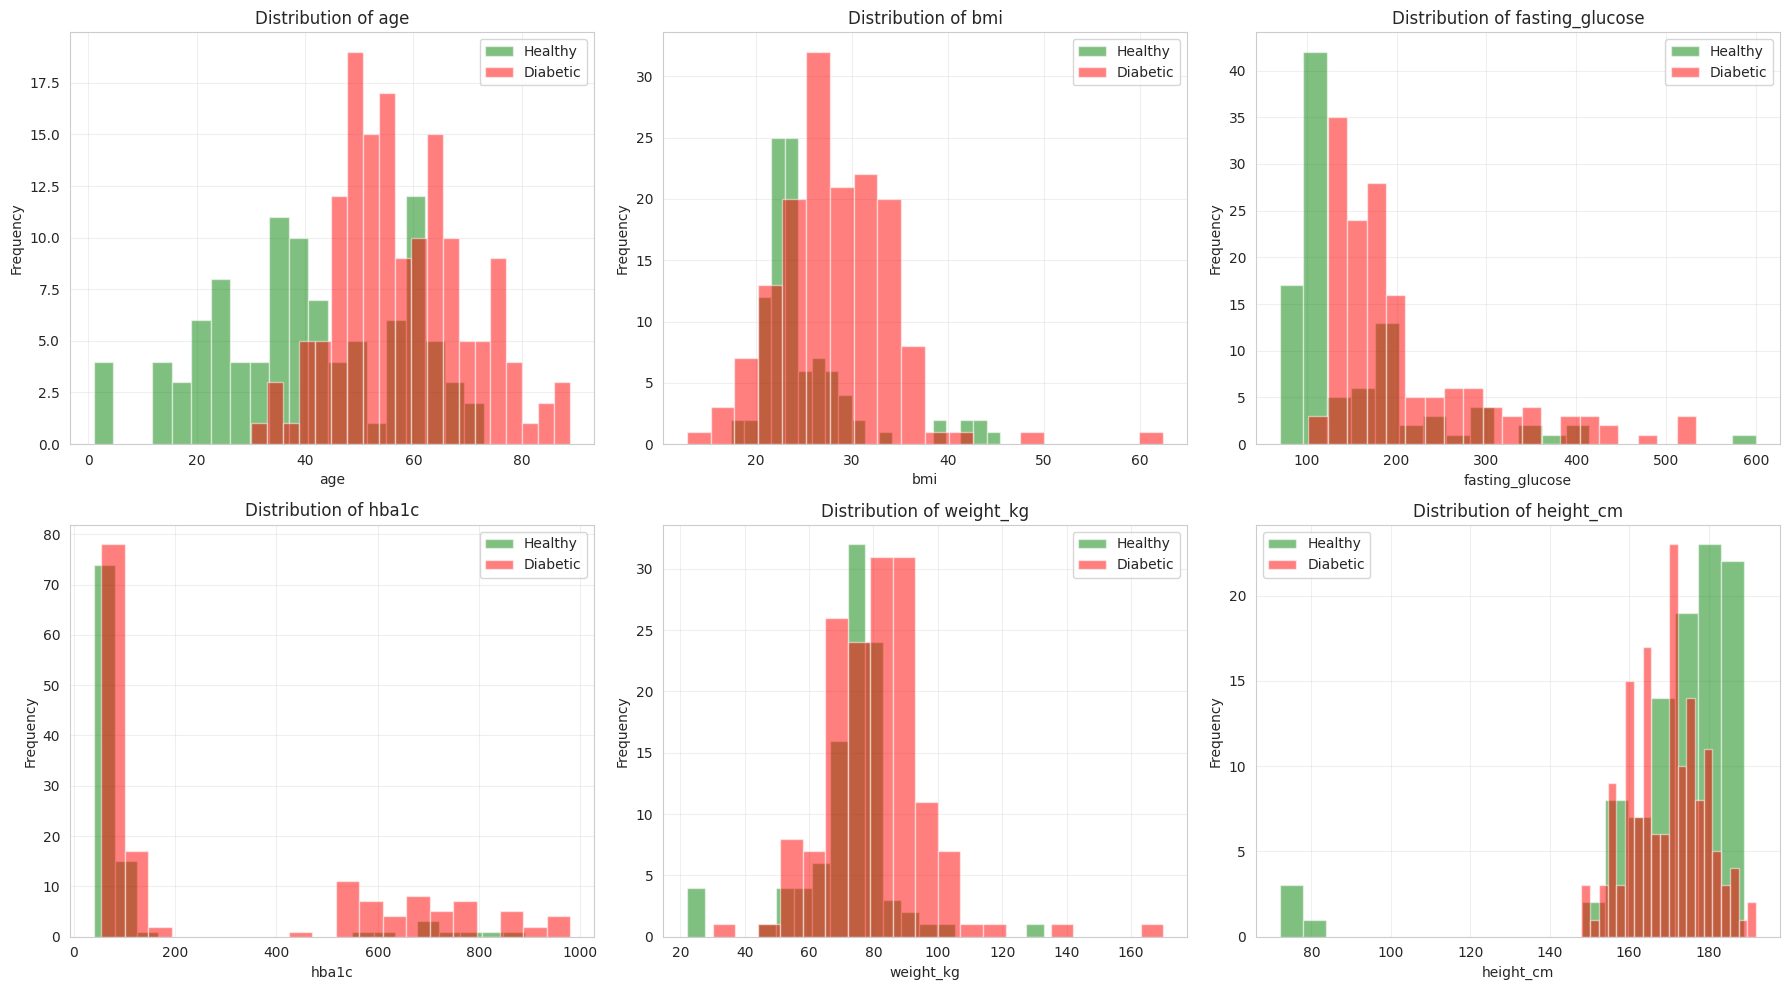

In [66]:
# Visualize feature distributions by class
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

numerical_features = ['age', 'bmi', 'fasting_glucose', 'hba1c', 'weight_kg', 'height_cm']

for idx, feature in enumerate(numerical_features):
    ax = axes[idx // 3, idx % 3]
    df[df['target'] == 0][feature].hist(ax=ax, alpha=0.5, label='Healthy', bins=20, color='green')
    df[df['target'] == 1][feature].hist(ax=ax, alpha=0.5, label='Diabetic', bins=20, color='red')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    ax.set_title(f'Distribution of {feature}')
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

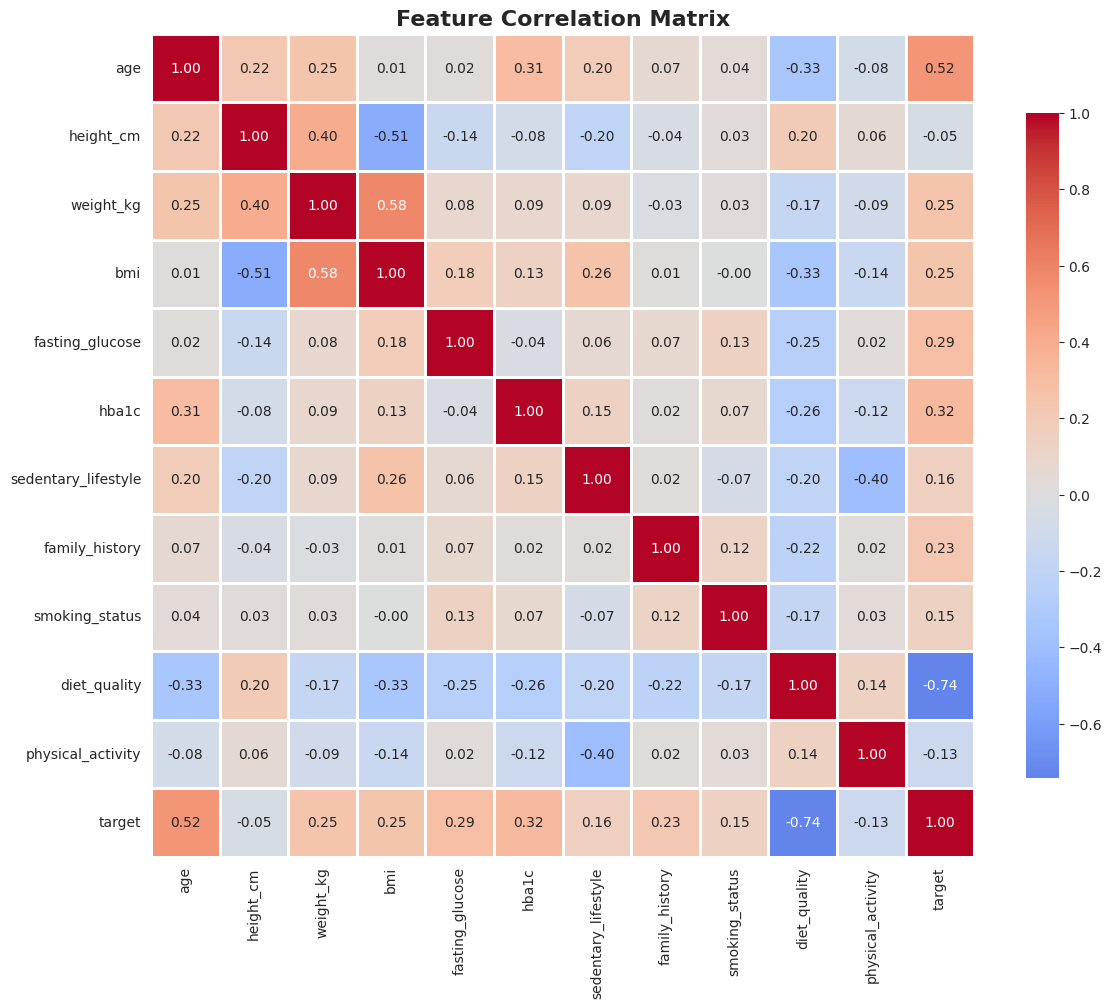

In [67]:
# Correlation matrix
plt.figure(figsize=(12, 10))
correlation = df.drop('patient_id', axis=1).corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='coolwarm', center=0,
           square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('../reports/correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. Feature Engineering

In [68]:
# Create additional features
df_fe = df.copy()

# Age groups (one-hot encoded)
df_fe['age_young'] = (df_fe['age'] < 30).astype(int)
df_fe['age_middle'] = ((df_fe['age'] >= 30) & (df_fe['age'] < 50)).astype(int)
df_fe['age_senior'] = ((df_fe['age'] >= 50) & (df_fe['age'] < 65)).astype(int)
df_fe['age_elderly'] = (df_fe['age'] >= 65).astype(int)

# BMI categories
df_fe['bmi_underweight'] = (df_fe['bmi'] < 18.5).astype(int)
df_fe['bmi_normal'] = ((df_fe['bmi'] >= 18.5) & (df_fe['bmi'] < 25)).astype(int)
df_fe['bmi_overweight'] = ((df_fe['bmi'] >= 25) & (df_fe['bmi'] < 30)).astype(int)
df_fe['bmi_obese'] = (df_fe['bmi'] >= 30).astype(int)

# Glucose categories
df_fe['glucose_normal'] = (df_fe['fasting_glucose'] < 100).astype(int)
df_fe['glucose_prediabetic'] = ((df_fe['fasting_glucose'] >= 100) & 
                                (df_fe['fasting_glucose'] < 126)).astype(int)
df_fe['glucose_diabetic'] = (df_fe['fasting_glucose'] >= 126).astype(int)

# HbA1c categories
df_fe['hba1c_normal'] = (df_fe['hba1c'] < 5.7).astype(int)
df_fe['hba1c_prediabetic'] = ((df_fe['hba1c'] >= 5.7) & (df_fe['hba1c'] < 6.5)).astype(int)
df_fe['hba1c_diabetic'] = (df_fe['hba1c'] >= 6.5).astype(int)

# Risk score (composite feature)
df_fe['risk_score'] = (
    df_fe['sedentary_lifestyle'] * 2 +
    df_fe['family_history'] * 3 +
    (df_fe['smoking_status'] > 0).astype(int) * 1 +
    (df_fe['diet_quality'] == 0).astype(int) * 2 +
    (df_fe['physical_activity'] == 0).astype(int) * 2 +
    df_fe['bmi_obese'] * 2
)

# Interaction features
df_fe['bmi_x_age'] = df_fe['bmi'] * df_fe['age']
df_fe['glucose_x_hba1c'] = df_fe['fasting_glucose'] * df_fe['hba1c']
df_fe['lifestyle_score'] = df_fe['sedentary_lifestyle'] + (df_fe['physical_activity'] == 0).astype(int)

print(f"Original features: {df.shape[1]}")
print(f"After feature engineering: {df_fe.shape[1]}")
print(f"\nNew features created: {df_fe.shape[1] - df.shape[1]}")

Original features: 13
After feature engineering: 31

New features created: 18


## 4. Prepare Train/Validation/Test Sets

In [69]:
# Separate features and target
X = df_fe.drop(['patient_id', 'target'], axis=1)
y = df_fe['target']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature names:\n{X.columns.tolist()}")

Features shape: (250, 29)
Target shape: (250,)

Feature names:
['age', 'height_cm', 'weight_kg', 'bmi', 'fasting_glucose', 'hba1c', 'sedentary_lifestyle', 'family_history', 'smoking_status', 'diet_quality', 'physical_activity', 'age_young', 'age_middle', 'age_senior', 'age_elderly', 'bmi_underweight', 'bmi_normal', 'bmi_overweight', 'bmi_obese', 'glucose_normal', 'glucose_prediabetic', 'glucose_diabetic', 'hba1c_normal', 'hba1c_prediabetic', 'hba1c_diabetic', 'risk_score', 'bmi_x_age', 'glucose_x_hba1c', 'lifestyle_score']


In [70]:
# Split data: 60% train, 20% validation, 20% test
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp  # 0.25 of 0.8 = 0.2
)

print("Data split:")
print(f"Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

print("\nClass distribution in train set:")
print(y_train.value_counts())
print(f"\nClass balance in train: {y_train.value_counts(normalize=True) * 100}")

Data split:
Train: 150 samples (60.0%)
Validation: 50 samples (20.0%)
Test: 50 samples (20.0%)

Class distribution in train set:
target
1    91
0    59
Name: count, dtype: int64

Class balance in train: target
1    60.666667
0    39.333333
Name: proportion, dtype: float64


In [71]:
# Scale numerical features
scaler = StandardScaler()

# Identify numerical columns (exclude binary/categorical)
numerical_cols = ['age', 'height_cm', 'weight_kg', 'bmi', 'fasting_glucose', 
                 'hba1c', 'risk_score', 'bmi_x_age', 'glucose_x_hba1c']

# Fit on train, transform all sets
X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_val_scaled[numerical_cols] = scaler.transform(X_val[numerical_cols])
X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

# Save scaler for later use
joblib.dump(scaler, '../data/scaler.pkl')

print("Feature scaling completed")
print(f"\nScaled features: {numerical_cols}")

Feature scaling completed

Scaled features: ['age', 'height_cm', 'weight_kg', 'bmi', 'fasting_glucose', 'hba1c', 'risk_score', 'bmi_x_age', 'glucose_x_hba1c']


## 5. Handle Class Imbalance with SMOTE

In [72]:
# Check if class imbalance exists
class_counts = y_train.value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()

print(f"Class imbalance ratio: {imbalance_ratio:.2f}")

if imbalance_ratio > 1.5:
    print("\nApplying SMOTE to balance classes...")
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
    
    print(f"\nBefore SMOTE: {X_train_scaled.shape}")
    print(f"After SMOTE: {X_train_resampled.shape}")
    print(f"\nClass distribution after SMOTE:")
    print(pd.Series(y_train_resampled).value_counts())
else:
    print("\nClasses are relatively balanced, no SMOTE needed")
    X_train_resampled = X_train_scaled
    y_train_resampled = y_train

Class imbalance ratio: 1.54

Applying SMOTE to balance classes...

Before SMOTE: (150, 29)
After SMOTE: (182, 29)

Class distribution after SMOTE:
target
0    91
1    91
Name: count, dtype: int64


## 6. Baseline Model 1: Random Forest

In [73]:
# Train Random Forest
print("Training Random Forest Classifier...")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=10,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_val_pred_rf = rf_model.predict(X_val_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)

# Prediction probabilities
y_train_proba_rf = rf_model.predict_proba(X_train_scaled)[:, 1]
y_val_proba_rf = rf_model.predict_proba(X_val_scaled)[:, 1]
y_test_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

print("✓ Random Forest training completed")

Training Random Forest Classifier...
✓ Random Forest training completed
✓ Random Forest training completed


In [74]:
# Evaluate Random Forest
def evaluate_model(y_true, y_pred, y_proba, model_name, dataset_name):
    print(f"\n{'='*60}")
    print(f"{model_name} - {dataset_name} Set")
    print('='*60)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_proba)
    
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    
    print(f"\nConfusion Matrix:")
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    
    print(f"\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Healthy', 'Diabetic']))
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }

rf_train_metrics = evaluate_model(y_train, y_train_pred_rf, y_train_proba_rf, 
                                  "Random Forest", "Train")
rf_val_metrics = evaluate_model(y_val, y_val_pred_rf, y_val_proba_rf, 
                                "Random Forest", "Validation")
rf_test_metrics = evaluate_model(y_test, y_test_pred_rf, y_test_proba_rf, 
                                 "Random Forest", "Test")


Random Forest - Train Set
Accuracy:  0.9800
Precision: 0.9681
Recall:    1.0000
F1-Score:  0.9838
ROC-AUC:   1.0000

Confusion Matrix:
[[56  3]
 [ 0 91]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       1.00      0.95      0.97        59
    Diabetic       0.97      1.00      0.98        91

    accuracy                           0.98       150
   macro avg       0.98      0.97      0.98       150
weighted avg       0.98      0.98      0.98       150


Random Forest - Validation Set
Accuracy:  0.9800
Precision: 1.0000
Recall:    0.9667
F1-Score:  0.9831
ROC-AUC:   1.0000

Confusion Matrix:
[[20  0]
 [ 1 29]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.95      1.00      0.98        20
    Diabetic       1.00      0.97      0.98        30

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98     

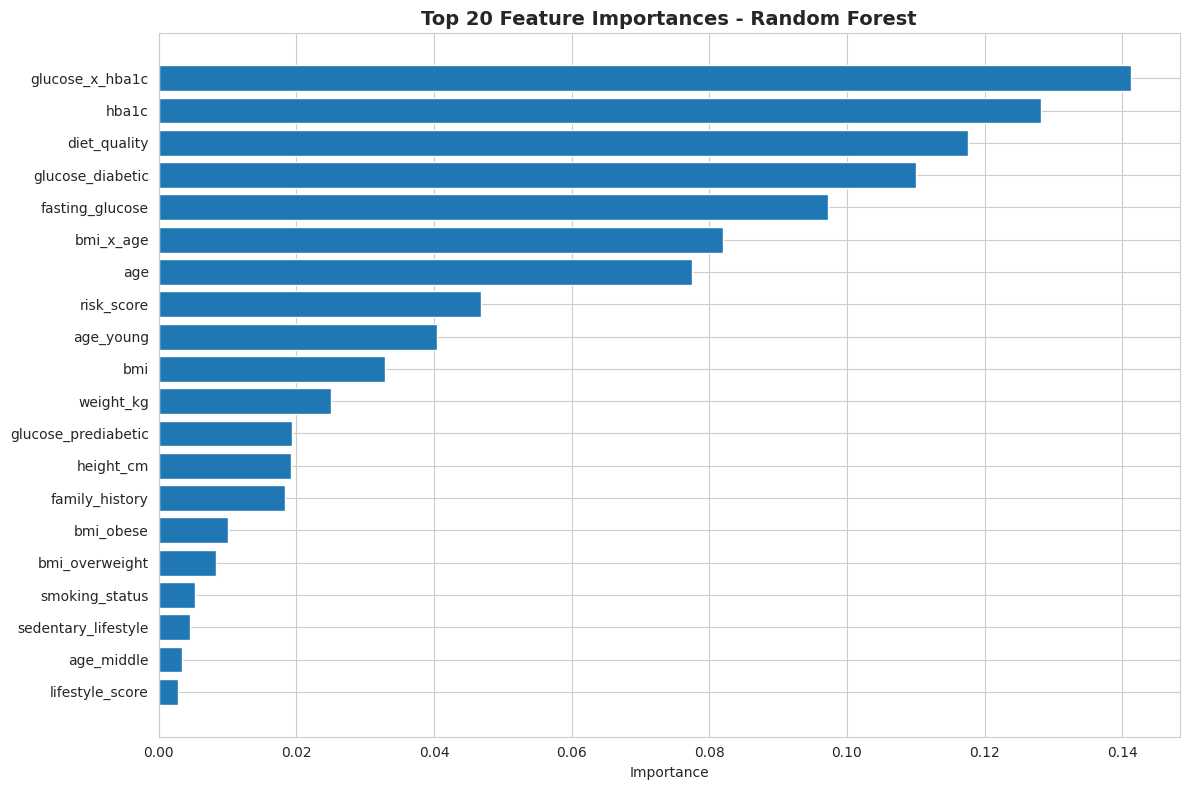


Top 10 Most Important Features:
             feature  importance
27   glucose_x_hba1c    0.141313
5              hba1c    0.128185
9       diet_quality    0.117629
21  glucose_diabetic    0.110068
4    fasting_glucose    0.097215
26         bmi_x_age    0.081953
0                age    0.077464
25        risk_score    0.046849
11         age_young    0.040450
3                bmi    0.032936


In [75]:
# Feature importance for Random Forest
feature_importance_rf = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_rf['feature'][:20], feature_importance_rf['importance'][:20])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - Random Forest', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../reports/rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance_rf.head(10))

## 7. Baseline Model 2: XGBoost

In [76]:
# Train XGBoost
print("Training XGBoost Classifier...")

# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    min_child_weight=3,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

# Train model
xgb_model.fit(X_train_scaled, y_train, verbose=False)

# Predictions
y_train_pred_xgb = xgb_model.predict(X_train_scaled)
y_val_pred_xgb = xgb_model.predict(X_val_scaled)
y_test_pred_xgb = xgb_model.predict(X_test_scaled)

# Prediction probabilities
y_train_proba_xgb = xgb_model.predict_proba(X_train_scaled)[:, 1]
y_val_proba_xgb = xgb_model.predict_proba(X_val_scaled)[:, 1]
y_test_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

print("✓ XGBoost training completed")

Training XGBoost Classifier...
✓ XGBoost training completed
✓ XGBoost training completed


In [77]:
# Evaluate XGBoost
xgb_train_metrics = evaluate_model(y_train, y_train_pred_xgb, y_train_proba_xgb, 
                                   "XGBoost", "Train")
xgb_val_metrics = evaluate_model(y_val, y_val_pred_xgb, y_val_proba_xgb, 
                                 "XGBoost", "Validation")
xgb_test_metrics = evaluate_model(y_test, y_test_pred_xgb, y_test_proba_xgb, 
                                  "XGBoost", "Test")


XGBoost - Train Set
Accuracy:  0.9467
Precision: 0.9663
Recall:    0.9451
F1-Score:  0.9556
ROC-AUC:   0.9944

Confusion Matrix:
[[56  3]
 [ 5 86]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.92      0.95      0.93        59
    Diabetic       0.97      0.95      0.96        91

    accuracy                           0.95       150
   macro avg       0.94      0.95      0.94       150
weighted avg       0.95      0.95      0.95       150


XGBoost - Validation Set
Accuracy:  0.9400
Precision: 1.0000
Recall:    0.9000
F1-Score:  0.9474
ROC-AUC:   0.9967

Confusion Matrix:
[[20  0]
 [ 3 27]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.87      1.00      0.93        20
    Diabetic       1.00      0.90      0.95        30

    accuracy                           0.94        50
   macro avg       0.93      0.95      0.94        50
weighted avg       0.95      0.94      0.94       

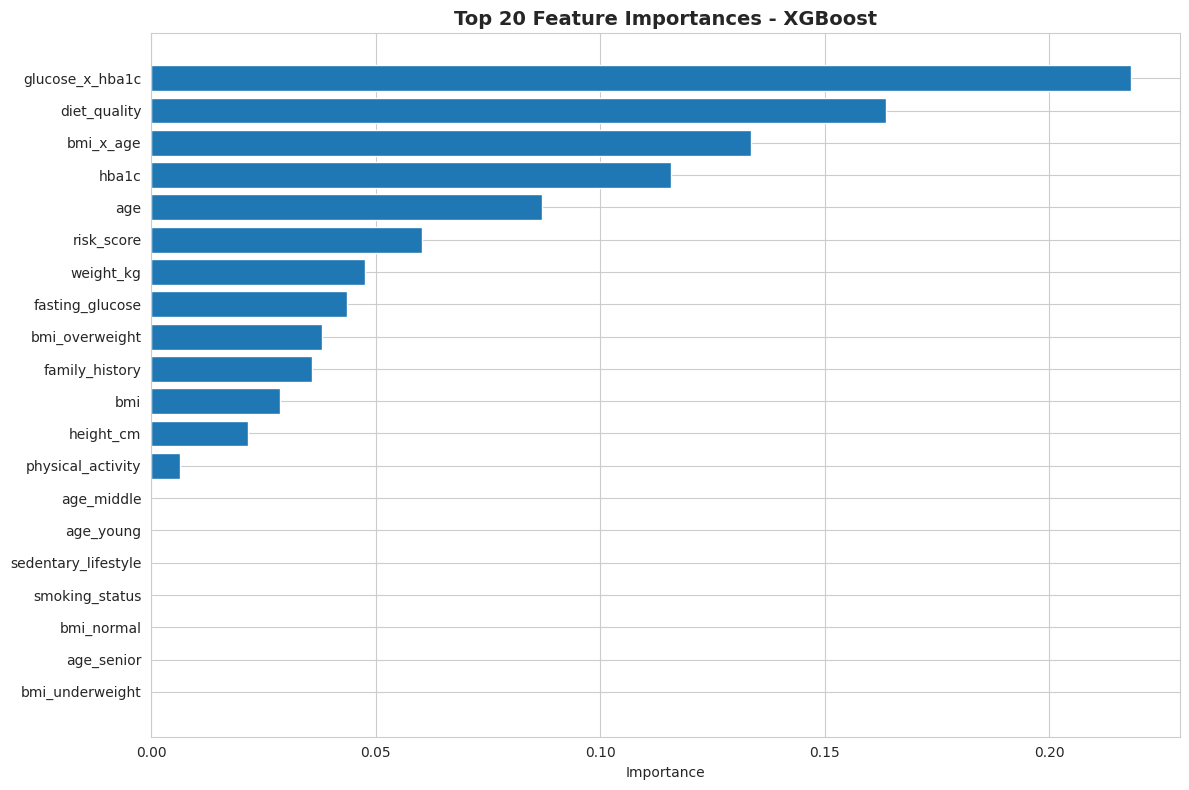


Top 10 Most Important Features:
            feature  importance
27  glucose_x_hba1c    0.218172
9      diet_quality    0.163641
26        bmi_x_age    0.133585
5             hba1c    0.115715
0               age    0.087086
25       risk_score    0.060401
2         weight_kg    0.047517
4   fasting_glucose    0.043604
17   bmi_overweight    0.037946
7    family_history    0.035777


In [78]:
# Feature importance for XGBoost
feature_importance_xgb = pd.DataFrame({
    'feature': X_train_scaled.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importance_xgb['feature'][:20], feature_importance_xgb['importance'][:20])
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances - XGBoost', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../reports/xgb_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance_xgb.head(10))

## 8. Model Comparison

In [79]:
# Create comparison dataframe
comparison_df = pd.DataFrame([
    {'Model': 'Random Forest', 'Set': 'Train', **rf_train_metrics},
    {'Model': 'Random Forest', 'Set': 'Validation', **rf_val_metrics},
    {'Model': 'Random Forest', 'Set': 'Test', **rf_test_metrics},
    {'Model': 'XGBoost', 'Set': 'Train', **xgb_train_metrics},
    {'Model': 'XGBoost', 'Set': 'Validation', **xgb_val_metrics},
    {'Model': 'XGBoost', 'Set': 'Test', **xgb_test_metrics}
])

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))

# Save comparison
comparison_df.to_csv('../reports/baseline_models_comparison.csv', index=False)
print("\n✓ Comparison saved to ../reports/baseline_models_comparison.csv")


MODEL COMPARISON
        Model        Set  accuracy  precision   recall       f1  roc_auc
Random Forest      Train  0.980000   0.968085 1.000000 0.983784 1.000000
Random Forest Validation  0.980000   1.000000 0.966667 0.983051 1.000000
Random Forest       Test  0.940000   0.935484 0.966667 0.950820 0.991667
      XGBoost      Train  0.946667   0.966292 0.945055 0.955556 0.994412
      XGBoost Validation  0.940000   1.000000 0.900000 0.947368 0.996667
      XGBoost       Test  0.940000   0.909091 1.000000 0.952381 0.988333

✓ Comparison saved to ../reports/baseline_models_comparison.csv


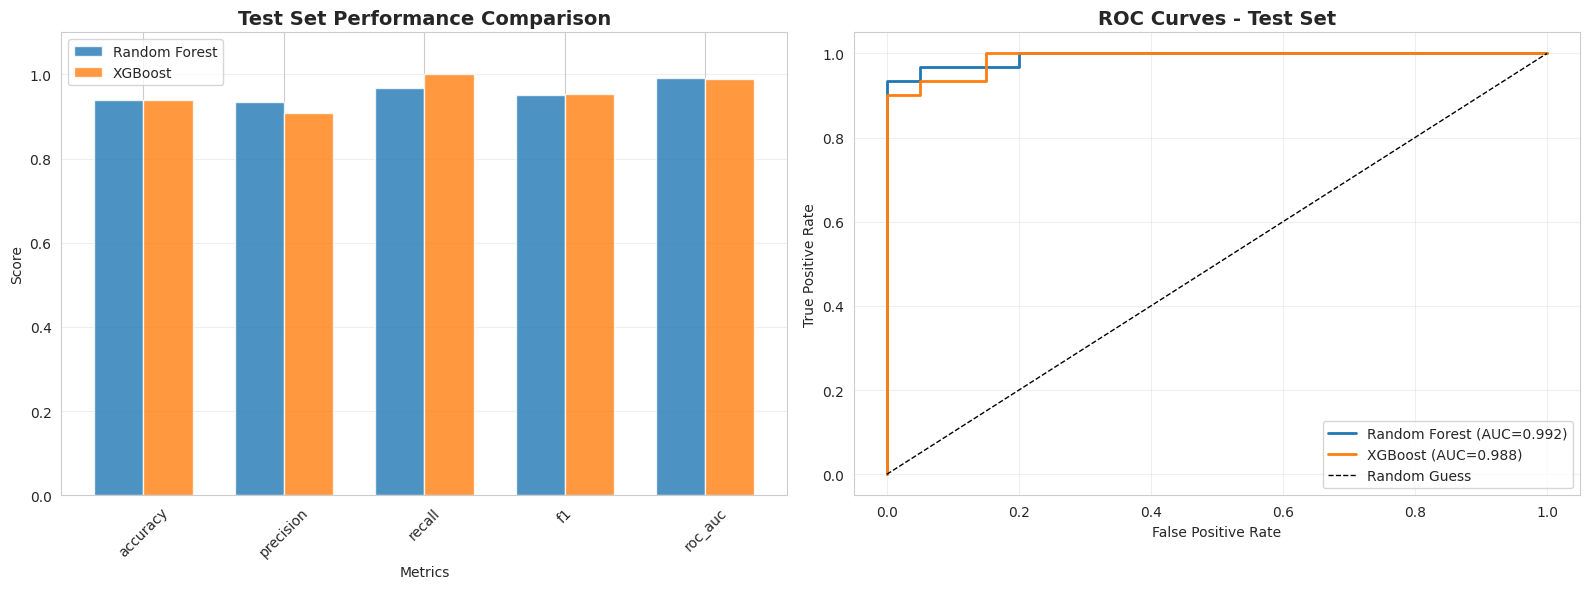

In [80]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
test_comparison = comparison_df[comparison_df['Set'] == 'Test']

# Plot 1: Metrics comparison
x = np.arange(len(metrics))
width = 0.35

rf_scores = test_comparison[test_comparison['Model'] == 'Random Forest'][metrics].values[0]
xgb_scores = test_comparison[test_comparison['Model'] == 'XGBoost'][metrics].values[0]

axes[0].bar(x - width/2, rf_scores, width, label='Random Forest', alpha=0.8)
axes[0].bar(x + width/2, xgb_scores, width, label='XGBoost', alpha=0.8)
axes[0].set_xlabel('Metrics')
axes[0].set_ylabel('Score')
axes[0].set_title('Test Set Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=45)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0, 1.1])

# Plot 2: ROC Curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_proba_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_test_proba_xgb)

axes[1].plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={rf_test_metrics["roc_auc"]:.3f})', linewidth=2)
axes[1].plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC={xgb_test_metrics["roc_auc"]:.3f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Guess', linewidth=1)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves - Test Set', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/baseline_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 9. Cross-Validation

In [81]:
# Perform 5-fold stratified cross-validation
print("Performing 5-fold cross-validation...\n")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Random Forest CV
rf_cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, 
                               cv=cv, scoring='roc_auc', n_jobs=-1)
print(f"Random Forest CV ROC-AUC Scores: {rf_cv_scores}")
print(f"Mean: {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std() * 2:.4f})")

# XGBoost CV
xgb_cv_scores = cross_val_score(xgb_model, X_train_scaled, y_train, 
                                cv=cv, scoring='roc_auc', n_jobs=-1)
print(f"\nXGBoost CV ROC-AUC Scores: {xgb_cv_scores}")
print(f"Mean: {xgb_cv_scores.mean():.4f} (+/- {xgb_cv_scores.std() * 2:.4f})")

Performing 5-fold cross-validation...

Random Forest CV ROC-AUC Scores: [0.98611111 0.99537037 0.97685185 1.         0.98564593]
Mean: 0.9888 (+/- 0.0162)
Random Forest CV ROC-AUC Scores: [0.98611111 0.99537037 0.97685185 1.         0.98564593]
Mean: 0.9888 (+/- 0.0162)

XGBoost CV ROC-AUC Scores: [0.90277778 1.         0.9537037  0.98148148 0.97129187]
Mean: 0.9619 (+/- 0.0662)

XGBoost CV ROC-AUC Scores: [0.90277778 1.         0.9537037  0.98148148 0.97129187]
Mean: 0.9619 (+/- 0.0662)


## 10. Save Models

In [82]:
# Save trained models
joblib.dump(rf_model, '../data/random_forest_model.pkl')
joblib.dump(xgb_model, '../data/xgboost_model.pkl')

# Save feature names
with open('../data/feature_names.txt', 'w') as f:
    f.write('\n'.join(X_train_scaled.columns.tolist()))

# Save datasets for next notebooks
joblib.dump((X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test), 
           '../data/processed_datasets.pkl')

print("✓ Models and datasets saved successfully")
print("\n✓ Part 2.1 (Baseline Models) completed!")

✓ Models and datasets saved successfully

✓ Part 2.1 (Baseline Models) completed!
